In [16]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
import gc
import xgboost as xgb
import numpy as np
import re
import pandas as pd
from sklearn.model_selection import train_test_split

out_path = r'.'
df = pd.read_csv(r'data/bio/all_2.csv', header=None)
df.columns = ['sentence_id', 'intent', 'language', 'written', 'spoken','type', 'token', 'token_id', 'tag']
df.sentence_id = df.sentence_id.astype(int)
df.token_id.fillna(0, inplace=True)
df.token.fillna('<sos>', inplace=True)
df.token_id = df.token_id.astype(int)
df

,sentence_id,intent,language,written,spoken,type,token,token_id,tag
0,0,Pad,NaN,NaN,NaN,plain,<sos>,0,O
1,0,OpenArea,en,show,show,plain,show,1,O
2,0,OpenArea,en,newest uploads,newest uploads,mycloudarea,newest,2,O
3,0,OpenArea,en,newest uploads,newest uploads,mycloudarea,uploads,2,O
4,0,OpenArea,en,on,on,plain,on,3,O
...,...,...,...,...,...,...,...,...,...
1843349,173970,Pad,NaN,NaN,NaN,plain,<sos>,0,O
1843350,173970,WatchNextEpisode,en,one,one,plain,one,1,O
1843351,173970,WatchNextEpisode,en,more,more,plain,more,2,O
1843352,173970,WatchNextEpisode,en,episode,episode,plain,episode,3,O


In [18]:
import random
test_ratio = 0.1
random.seed(10)
max_id = max(df.sentence_id)
sentence_id = list(range(max_id))
random.shuffle(sentence_id)
t = int(test_ratio * max_id)
test_id = sentence_id[:t]
train_id = sentence_id[t:]

train = df[df['sentence_id'].isin(train_id)]
test = df[df['sentence_id'].isin(test_id)]


In [3]:
def context_window_transform(data, pad_size, boundary_letter, max_num_features):
    pre = np.zeros(max_num_features)
    pre = [pre for x in np.arange(pad_size)]
    data = pre + data + pre
    neo_data = []
    for i in tqdm(np.arange(len(data) - pad_size * 2)):
        row = []
        for x in data[i : i + pad_size * 2 + 1]:
            row.append([boundary_letter])
            row.append(x)
        row.append([boundary_letter])
        neo_data.append([int(x) for y in row for x in y])
    return neo_data

def load_data(df, max_num_features=10, pad_size=1, boundary_letter=-1, space_letter=0, max_data_size=-1):
    x_data = []
    y_data =  pd.factorize(df['tag'])
    labels = y_data[1]
    y_data = y_data[0]
    gc.collect()
    for x in tqdm(df['token'].values):
        x_row = np.ones(max_num_features, dtype=int) * space_letter
        for xi, i in zip(list(str(x)), np.arange(max_num_features)):
            x_row[i] = ord(xi)
        x_data.append(x_row)

    x_data = x_data[:max_data_size]
    y_data = y_data[:max_data_size]
    x_data = np.array(context_window_transform(x_data, pad_size, boundary_letter, max_num_features))
    gc.collect()
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    print('Total number of samples:', len(x_data))
    print('Use: ', max_data_size)
    print('x_data sample:')
    print(x_data[0])
    print('y_data sample:')
    print(y_data[0])
    print('labels:')
    print(labels)

    return x_data, y_data, labels

In [4]:
max_num_features = 10
pad_size = 1
boundary_letter = -1
space_letter = 0
max_data_size = -1

print("Train set:")
x_train, y_train, labels_train = load_data(train,
                                           max_num_features=max_num_features,
                                           pad_size=pad_size,
                                           boundary_letter=boundary_letter,
                                           space_letter=space_letter,
                                           max_data_size=max_data_size)
gc.collect()
print()

print("Valid set:")
x_valid, y_valid, labels_valid = load_data(test,
                                           max_num_features=max_num_features,
                                           pad_size=pad_size,
                                           boundary_letter=boundary_letter,
                                           space_letter=space_letter,
                                           max_data_size=max_data_size)
gc.collect()
print()


100%|██████████| 184955/184955 [00:02<00:00, 82551.47it/s]


Train set:
Total number of samples: 1658460
Use:  -1
x_data sample:
[ -1   0   0   0   0   0   0   0   0   0   0  -1  60 115 111 115  62   0
   0   0   0   0  -1 115 104 111 119   0   0   0   0   0   0  -1]
y_data sample:
0
labels:
Index(['O', 'B-TBNorm', 'I-TBNorm'], dtype='object')

Valid set:
Total number of samples: 184955
Use:  -1
x_data sample:
[ -1   0   0   0   0   0   0   0   0   0   0  -1  60 115 111 115  62   0
   0   0   0   0  -1 115 104 111 119   0   0   0   0   0   0  -1]
y_data sample:
0
labels:
Index(['O', 'B-TBNorm', 'I-TBNorm'], dtype='object')



In [5]:
labels = labels_train
num_class = len(labels)
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(dvalid, 'valid'), (dtrain, 'train')]

param = {'objective':'multi:softmax',
         'eta':'0.3', 'max_depth':10,
         'silent':1, 'nthread':-1,
         'num_class':num_class,
         'eval_metric':'merror'}
model = xgb.train(param, dtrain, 500, watchlist, early_stopping_rounds=20, verbose_eval=10)
# model = xgb.Booster({'nthread': -1})  # init model
# model.load_model(os.path.join(out_path, 'xgb_model'))
gc.collect()

pred = model.predict(dvalid)
pred = [labels[int(x)] for x in pred]
y_valid = [labels[x] for x in y_valid]
x_valid = [ [ chr(x) for x in y[2 + max_num_features: 2 + max_num_features * 2]] for y in x_valid]
x_valid = [''.join(x) for x in x_valid]
x_valid = [re.sub('a+$', '', x) for x in x_valid]

gc.collect()

df_pred = pd.DataFrame(columns=['data', 'predict', 'target'])
df_pred['data'] = x_valid
df_pred['predict'] = pred
df_pred['target'] = y_valid
df_pred.to_csv(os.path.join(out_path, 'pred.csv'))

df_erros = df_pred.loc[df_pred['predict'] != df_pred['target']]
df_erros.to_csv(os.path.join(out_path, 'errors.csv'), index=False)
model.save_model(os.path.join(out_path, 'xgb_model'))

[0]	valid-merror:0.03056	train-merror:0.03032
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 20 rounds.
[10]	valid-merror:0.01207	train-merror:0.01184
[20]	valid-merror:0.00650	train-merror:0.00646
[30]	valid-merror:0.00434	train-merror:0.00411
[40]	valid-merror:0.00375	train-merror:0.00339
[50]	valid-merror:0.00338	train-merror:0.00289
[60]	valid-merror:0.00322	train-merror:0.00262
[70]	valid-merror:0.00305	train-merror:0.00241
[80]	valid-merror:0.00294	train-merror:0.00224
[90]	valid-merror:0.00289	train-merror:0.00215
[100]	valid-merror:0.00283	train-merror:0.00208
[110]	valid-merror:0.00282	train-merror:0.00203
[120]	valid-merror:0.00280	train-merror:0.00200
[130]	valid-merror:0.00280	train-merror:0.00199
[140]	valid-merror:0.00278	train-merror:0.00196
[150]	valid-merror:0.00276	train-merror:0.00195
[160]	valid-merror:0.00276	train-merror:0.00195
[170]	valid-merror:0.00275	train-merror:0.0019

In [6]:
test

,sentence_id,intent,language,written,spoken,type,token,token_id,tag
211,32,Pad,NaN,NaN,NaN,plain,<sos>,0,O
212,32,OpenArea,en,show,show,plain,show,1,O
213,32,OpenArea,en,clips,clips,mycloudarea,clips,2,O
214,32,OpenArea,en,on,on,plain,on,3,O
215,32,OpenArea,en,mycloud,mycloud,plain,mycloud,4,O
...,...,...,...,...,...,...,...,...,...
1843234,173935,NavigationUp,en,can,can,plain,can,1,O
1843235,173935,NavigationUp,en,you,you,plain,you,2,O
1843236,173935,NavigationUp,en,go,go,plain,go,3,O
1843237,173935,NavigationUp,en,up,up,plain,up,4,O


In [6]:
df_erros = pd.read_csv('errors.csv')
df_pred = pd.read_csv('pred.csv')
df_pred

,Unnamed: 0,data,predict,target
0,0,<sep>,O,O
1,1,folders,O,O
2,2,in,O,O
3,3,mycloud,O,O
4,4,<sep>,O,O
...,...,...,...,...
166670,166670,all,O,O
166671,166671,ikea,O,O
166672,166672,in,O,O
166673,166673,the,O,O


In [24]:
k = test.copy()
k = k.reset_index(drop=True).iloc[:-1]
# k['tag'] = df_pred.predict
# k = k[k.intent != 'Pad']
k = k[['sentence_id', 'token', 'tag']]
k

,sentence_id,token,tag
0,32,<sos>,O
1,32,show,O
2,32,clips,O
3,32,on,O
4,32,mycloud,O
...,...,...,...
184880,173935,<sos>,O
184881,173935,can,O
184882,173935,you,O
184883,173935,go,O


In [25]:
tag_before = 'O'
token_buffer = []
id_before = -1
k.sentence_id = k.sentence_id.astype(str)
with open('pred_id.csv', 'w') as outfile:
    for i, row in tqdm(k.iterrows()):
        item = {}
        if row['tag'] == 'O':
            if token_buffer:
                # output buffer
                item['sentence_id'] = id_before
                item['token'] = ' '.join(token_buffer)
                item['tag'] = 'B'
                token_buffer = []
                outfile.write(','.join(item.values()) + '\n')

            # output self
            item['sentence_id'] = row['sentence_id']
            item['token'] = row['token']
            item['tag'] = 'O'
            tag_before = 'O'
            id_before = row['sentence_id']
            outfile.write(','.join(item.values()) + '\n')
        else:
            token_buffer.append(row['token'])
            id_before = row['sentence_id']

184885it [00:16, 10906.15it/s]


In [26]:
r = pd.read_csv('pred_id.csv', header=None)
r = r[r[1] != '<sos>']
r = r.groupby([0], as_index = False).agg({1: ' '.join})
r

,0,1
0,32,show clips on mycloud
1,40,photo albums in mycloud
2,74,play photo albums on mycloud
3,77,play favourite pictures on mycloud
4,80,play favourite on mycloud
...,...,...
17392,173894,please record this show
17393,173905,save for later
17394,173926,move to the right
17395,173927,go one to the right


In [19]:
t = test.copy()
t = t[['sentence_id', 'token_id', 'language', 'written', 'spoken']]
t = t.drop_duplicates()
t = t[t.token_id != 0]
t = t.groupby(['sentence_id'], as_index = False).agg({'spoken': ' '.join})
t

,sentence_id,spoken
0,32,show clips on mycloud
1,40,photo albums in mycloud
2,74,play photo albums on mycloud
3,77,play favourite pictures on mycloud
4,80,play favourite on mycloud
...,...,...
17392,173894,please record this show
17393,173905,save for later
17394,173926,move to the right
17395,173927,go one to the right


In [27]:
r.columns = t.columns
t.compare(r)

Empty DataFrame
Columns: []
Index: []

In [7]:
from sklearn.metrics import classification_report as report
print(report(df_pred.predict, df_pred.target))


              precision    recall  f1-score   support

    B-TBNorm       0.98      0.99      0.99     10694
    I-TBNorm       1.00      0.99      0.99     30916
           O       1.00      1.00      1.00    143345

    accuracy                           1.00    184955
   macro avg       0.99      0.99      0.99    184955
weighted avg       1.00      1.00      1.00    184955



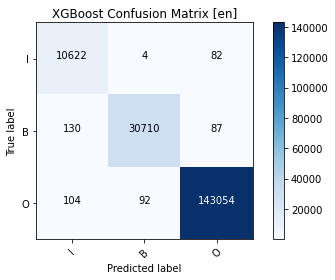

In [29]:
from sklearn.metrics import confusion_matrix as cm
from classification_report import  plot_confusion_matrix
matrix = cm(df_pred.predict, df_pred.target)
plot_confusion_matrix(matrix, classes=['I', 'B', 'O'],
                      title='XGBoost Confusion Matrix [{}]'.format('en'))


In [35]:
# use Opennmt
from helper import replace_space, make_src_tgt
from pathlib import Path
def prepare_onmt(df, name):
    data = df[df.tag != 'O']
    data = data[['sentence_id', 'token_id', 'language', 'written', 'spoken']]
    data = data.drop_duplicates().astype(str)
    data['tgt_char'] = data.written.apply(replace_space)
    data['src_char'] = data.spoken.apply(replace_space)
    make_src_tgt(data, name, data_output_dir=Path('.'), encoder_level='char', decoder_level='char')

prepare_onmt(train, 'train')
prepare_onmt(test, 'valid')

,sentence_id,token_id,language,written,spoken,tgt_char,src_char
8962,1062,2,en,yahoo news & finance,yahoo news and finance,y a h o o _ n e w s _ & _ f i n a n c e,y a h o o _ n e w s _ a n d _ f i n a n c e
8978,1065,2,en,sun&moon,sun and moon,s u n & m o o n,s u n _ a n d _ m o o n
9037,1078,2,en,abc 7 tampa area news,abc seven tampa area news,a b c _ 7 _ t a m p a _ a r e a _ n e w s,a b c _ s e v e n _ t a m p a _ a r e a _ n e w s
9055,1081,2,en,france 24 international news,france twenty four international news,f r a n c e _ 2 4 _ i n t e r n a t i o n a l ...,f r a n c e _ t w e n t y _ f o u r _ i n t e ...
9078,1085,2,en,nasa 1,nasa one,n a s a _ 1,n a s a _ o n e
...,...,...,...,...,...,...,...
1842269,173804,5,en,on 26.12,on twenty sixth december,o n _ 2 6 . 1 2,o n _ t w e n t y _ s i x t h _ d e c e m b e r
1842279,173805,5,en,on 27.12,on twenty seventh december,o n _ 2 7 . 1 2,o n _ t w e n t y _ s e v e n t h _ d e c e m ...
1842289,173806,5,en,on 28.12,on twenty eighth december,o n _ 2 8 . 1 2,o n _ t w e n t y _ e i g h t h _ d e c e m b e r
1842299,173807,5,en,on 29.12,on twenty ninth december,o n _ 2 9 . 1 2,o n _ t w e n t y _ n i n t h _ d e c e m b e r


In [46]:
from helper import replace_path_in_yaml
onmt_path = '../OpenNMT-py'
new_yaml_path = './ner/ner.yaml'
model = Path('ner') / '_step_{steps}.pt'.format( steps=10000)
output_path = 'ner/data/src_valid_pred.txt'

replace_path_in_yaml(yaml_path='./ner.yaml', new_yaml_path=new_yaml_path, model_path='./ner')
command_build_vocab = "python {onmt_path}/build_vocab.py -config  {yaml_path} -n_sample -1".format(
        onmt_path=onmt_path, yaml_path=new_yaml_path)
command_train = "python {onmt_path}/train.py -config {yaml_path}".format(onmt_path=onmt_path, yaml_path=new_yaml_path)

command_pred = "python {onmt_path}/translate.py -model {model} -src ner/data/src_valid.txt -output {output_path} " \
               "-beam_size {beam_size} -report_time".format(onmt_path=onmt_path, model=model,
                                                            output_path=output_path, beam_size=5)

256

In [ ]:
command_build_vocab

In [48]:
command_train

'python ../OpenNMT-py/train.py -config ./ner/ner.yaml'

In [56]:
command_pred

'python ../OpenNMT-py/translate.py -model ner/_step_10000.pt -src ner/data/src_valid.txt -output ner/data/src_valid_pred.txt -beam_size 5 -report_time'

In [67]:
from helper import recover_space
output_path = 'ner/data/src_valid_pred.txt'
data = pd.read_csv(output_path, sep="\n", header=None, skip_blank_lines=False)
data = data.fillna('')
data.columns = ["prediction_char"]
data['prediction_token'] = data["prediction_char"].apply(recover_space)
data['src']= pd.read_csv('ner/data/src_valid.txt', sep="\n", header=None, skip_blank_lines=False)[0].apply(recover_space)
data['tgt'] = pd.read_csv('ner/data/tgt_valid.txt', sep="\n", header=None, skip_blank_lines=False)[0].apply(recover_space)
data

,prediction_char,prediction_token,src,tgt
0,p i p e s _ 2,pipes 2,pipes two,pipes 2
1,o t t p l a y e r _ 2,ottplayer 2,ottplayer two,ottplayer 2
2,r u s t a v i _ 2,rustavi 2,rustavi two,rustavi 2
3,5,5,five,5
4,2 1,21,twenty one,21
...,...,...,...,...
10851,o n _ 1 . 1 2,on 1.12,on first december,on 1.12
10852,o n _ 2 . 1 2,on 2.12,on second december,on 2.12
10853,o n _ 1 0 . 1 2,on 10.12,on tenth december,on 10.12
10854,o n _ 2 2 . 1 2,on 22.12,on twenty second december,on 22.12


In [131]:
t = test.copy()
t = t[['sentence_id', 'token_id', 'language', 'written', 'spoken', 'tag']]
t.loc[t.tag!='O', 'tag'] = 'B'
t = t.drop_duplicates()
t = t[t.token_id != 0]
id_tobenormalized = t.index[t['tag']=='B'].tolist()
id_remainself = t.index[t['tag']=='O'].tolist()
print('Tokens to be normalized : {}'.format(len(id_tobenormalized)))
print('Tokens to remain self : {}'.format(len(id_remainself)))
t['after'] = ''
t.loc[id_tobenormalized, 'after'] = data['prediction_token'].tolist()
t.loc[id_remainself, 'after'] = t.loc[id_remainself, 'spoken']
t = t.groupby(['sentence_id'], as_index = False).agg({'spoken': ' '.join, 'written': ' '.join, 'after': ' '.join})

t

Tokens to be normalized : 10856
Tokens to remain self : 98279


,sentence_id,token_id,language,written,spoken,tag,after
212,32,1,en,show,show,O,show
213,32,2,en,clips,clips,O,clips
214,32,3,en,on,on,O,on
215,32,4,en,mycloud,mycloud,O,mycloud
260,40,1,en,photo albums,photo albums,O,photo albums
...,...,...,...,...,...,...,...
1843132,173927,5,en,right,right,O,right
1843166,173935,1,en,can,can,O,can
1843167,173935,2,en,you,you,O,you
1843168,173935,3,en,go,go,O,go


In [135]:
t

,sentence_id,spoken,written,after
0,32,show clips on mycloud,show clips on mycloud,show clips on mycloud
1,40,photo albums in mycloud,photo albums in mycloud,photo albums in mycloud
2,74,play photo albums on mycloud,play photo albums on mycloud,play photo albums on mycloud
3,77,play favourite pictures on mycloud,play favourite pictures on mycloud,play favourite pictures on mycloud
4,80,play favourite on mycloud,play favourite on mycloud,play favourite on mycloud
...,...,...,...,...
17392,173894,please record this show,please record this show,please record this show
17393,173905,save for later,save for later,save for later
17394,173926,move to the right,move to the right,move to the right
17395,173927,go one to the right,go one to the right,go one to the right


In [136]:
t[t.written != t.after]


,sentence_id,spoken,written,after
369,3569,change the radio station to hitradio ö three,change the radio station to hitradio ö 3,change the radio station to hitradio ö3
376,3669,change the radio station to bern one love and ...,change the radio station to bern1 love&relax,change the radio station to bern 1 love&relax
396,3817,change the radio station to my one hundred and...,change the radio station to my105 fresh,change the radio station to my 105 fresh
402,3856,change the radio station to swr two,change the radio station to swr2,change the radio station to swr 2
416,4011,change the radio station to bern one i love bärn,change the radio station to bern1 i love bärn,change the radio station to bern 1 i love bärn
...,...,...,...,...
10154,102002,could you rewind thirty seconds,could you rewind 30 seconds,could you rewind 32 seconds
10156,102022,could you rewind fifty seconds,could you rewind 50 seconds,could you rewind 52 seconds
10186,102329,fifty seconds forward,50 seconds forward,52 seconds forward
10201,102452,rewind twenty seconds please,rewind 20 seconds please,rewind 22 seconds please
